In [9]:
# 空间下采样：降低输入的空间分辨率来减少计算量和模型复杂度 并同时保留重要特征
import torch
from torch import nn
from d2l import torch as d2l
class Reshape(torch.nn.Module):
    def forward(self,x):# 1*28*28
        return x.view(-1,1,28,28)

net =nn.Sequential(
    # 输入是1 输出是6
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),# 卷积层出来是一个4d的东西 需要把最后的通道数 高宽 变成1维的向量  然后再输进多层感知机   
    nn.Flatten(),# 第一个维度保留 其他都拉成一个向量
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),# 120 降到84
    nn.Linear(84,10))




#     # net 代表网络，使用nn.Sequential按顺序构建神经网络模型
# net = nn.Sequential(
#     nn.Conv2d(1, 6, kernel_size=5, padding=2),  # nn.Conv2d是二维卷积层（Convolutional 2D），输入通道数为1，输出通道数为6，卷积核大小为5，padding（填充）为2
#     nn.Sigmoid(),  # 使用Sigmoid激活函数，对输出进行非线性变换
#     nn.AvgPool2d(kernel_size=2, stride=2),  # nn.AvgPool2d是二维平均池化层（Average Pooling 2D），池化核大小为2，步幅为2
#     nn.Conv2d(6, 16, kernel_size=5),  # 第二个卷积层，输入通道数为6，输出通道数为16，卷积核大小为5
#     nn.Sigmoid(),  # 使用Sigmoid激活函数
#     nn.AvgPool2d(kernel_size=2, stride=2),  # 第二个平均池化层，核大小为2，步幅为2
#     nn.Flatten(),  # nn.Flatten将多维张量展平为一维，保持第一个维度（批量大小），将其他维度展平成一个向量
#     nn.Linear(16 * 5 * 5, 120),  # nn.Linear是全连接层（Linear Layer），输入维度为16*5*5（卷积层输出展开后的大小），输出维度为120
#     nn.Sigmoid(),  # 使用Sigmoid激活函数
#     nn.Linear(120, 84),  # 第二个全连接层，输入维度为120，输出维度为84
#     nn.Sigmoid(),  # 使用Sigmoid激活函数
#     nn.Linear(84, 10)  # 最后一个全连接层，输入维度为84，输出维度为10，对应分类任务中的10个类别
# )


In [10]:
# 下面，我们将一个大小为28*28的单通道（黑白）图像通过LeNet。通过在每一层打印输出的形状，我们可以检查模型，以确保其操作与我们期望的一致。

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)  
# 生成一个随机张量X，形状为(1, 1, 28, 28)，表示一个大小为28x28的单通道图像，数据类型为float32（32位浮点数）

for layer in net:  # 把每一层拿出来 看形状
    # 遍历神经网络模型net中的每一层

    X = layer(X)  
    # 将输入X传递给当前遍历的层layer，输出结果继续传递给下一个layer

    print(layer.__class__.__name__, 'output shape: \t', X.shape)  
    # 输出当前层的类名称和该层输出的张量形状（即输出特征图的维度）


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [8]:
batch_size = 256  
# 定义批量大小，`batch_size` 表示每次训练或测试所使用的数据样本数量为 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
# 使用 d2l 库加载 Fashion-MNIST 数据集，返回训练数据迭代器 `train_iter` 和测试数据迭代器 `test_iter`
# `load_fashion_mnist` 是加载 Fashion-MNIST 数据集的函数，其中 `batch_size` 用于指定每个批次的数据量


100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [11]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  # 定义函数evaluate_accuracy_gpu，评估使用GPU时模型在数据集上的精度
    # net: 神经网络模型
    # data_iter: 数据迭代器
    # device: 计算设备，默认为None

    """使用GPU计算模型在数据集上的精度""" 

    if isinstance(net, nn.Module):  # 判断net是否是nn.Module的实例
        net.eval()  # 设置模型为评估模式，禁止dropout和batchnorm等的训练行为
        if not device:  # 如果device没有指定
            device = next(iter(net.parameters())).device  # 获取模型第一个参数的设备，并赋值给device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)  # 使用d2l库的Accumulator来累加两个值：正确预测的数量和总样本数
    # Accumulator是累加器，用于存储多个变量的累加值
    with torch.no_grad():  # 在torch.no_grad()上下文中，不计算梯度（提高评估效率）
        for X, y in data_iter:  # 遍历数据迭代器data_iter，X为输入，y为标签
            if isinstance(X, list):  # 如果X是一个列表
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]  # 将列表中的每个张量X转换到指定的设备上（GPU或CPU）
            else:
                X = X.to(device)  # 否则，将X转换到指定设备上
            y = y.to(device)  # 将标签y转换到指定设备上
            metric.add(d2l.accuracy(net(X), y), y.numel())  # 计算当前批次的准确率并累加到metric中，y.numel()为样本数量
            # d2l.accuracy是计算准确率的函数，numel()表示y的总元素个数，即样本数
    return metric[0] / metric[1]  # 返回累加的正确预测数与总样本数的比值，即准确率


In [12]:
# @save: 保存该函数，用于后续使用
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):  
    # 定义函数train_ch6，训练神经网络，使用GPU训练
    # net: 神经网络模型
    # train_iter: 训练数据的迭代器
    # test_iter: 测试数据的迭代器
    # num_epochs: 训练的轮数（epoch数）
    # lr: 学习率（learning rate的缩写）
    # device: 计算设备（如GPU或CPU）

    """用GPU训练模型(在第六章定义)"""  # 该函数的文档字符串，描述该函数是用于GPU上的训练函数

    def init_weights(m):  # 定义初始化权重的函数
        if type(m) == nn.Linear or type(m) == nn.Conv2d:  # 判断当前层是否为全连接层或卷积层
            # 用来调整权重 使得输入和输出方差差不多
            nn.init.xavier_uniform_(m.weight)  # 使用Xavier初始化方法对权重进行初始化

    net.apply(init_weights)  # 对网络net的所有层应用初始化权重的函数

    print('training on', device)  # 打印当前正在使用的计算设备（如GPU）

    net.to(device)  # 将模型net移至指定的计算设备

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  
    # 定义优化器optimizer，使用随机梯度下降法（Stochastic Gradient Descent, SGD）优化网络的参数，学习率为lr

    loss = nn.CrossEntropyLoss()  
    # 定义损失函数为交叉熵损失（CrossEntropyLoss），用于分类任务

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])  
    # 使用d2l库中的Animator类创建动画图，用于可视化训练损失、训练准确率和测试准确率

    timer, num_batches = d2l.Timer(), len(train_iter)  
    # 创建一个计时器timer，用于测量训练时间，num_batches表示训练集中批次数

    for epoch in range(num_epochs):  # 开始进行多个epoch的训练
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)  # 使用Accumulator累加器，用于累加训练损失、训练准确率和样本数量
        net.train()  # 将模型设置为训练模式
        for i, (X, y) in enumerate(train_iter):  # 遍历训练数据集的每个批次，X为输入数据，y为标签
            timer.start()  # 开始计时
            optimizer.zero_grad()  # 梯度清零
            X, y = X.to(device), y.to(device)  # 将输入数据和标签移动到计算设备上
            y_hat = net(X)  # 将输入数据传递到网络中，计算预测结果y_hat
            l = loss(y_hat, y)  # 计算损失，l为当前批次的损失
            l.backward()  # 反向传播计算梯度
            optimizer.step()  # 使用优化器更新网络参数
            with torch.no_grad():  # 禁用梯度计算，提高评估效率
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])  
                # 累加当前批次的损失、准确率和样本数。X.shape[0]是当前批次的样本数，d2l.accuracy计算准确率

            timer.stop()  # 停止计时
            train_l = metric[0] / metric[2]  # 计算训练集中的平均损失
            train_acc = metric[1] / metric[2]  # 计算训练集中的平均准确率
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:  
                # 每当完成一个epoch的1/5或最后一个批次时，更新动画图
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))  # 更新动画图，显示当前训练损失和准确率

        test_acc = evaluate_accuracy_gpu(net, test_iter)  # 计算模型在测试集上的准确率
        animator.add(epoch + 1, (None, None, test_acc))  # 更新动画图，显示测试准确率

    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')  # 打印训练损失、训练准确率和测试准确率

    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')  # 打印每秒处理的样本数，以及计算设备的信息


loss 0.469, train acc 0.822, test acc 0.800
10144.9 examples/sec on cpu


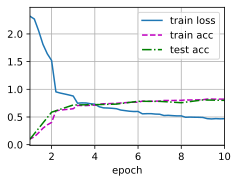

In [13]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())